In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Text Processing
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk

# Machine Learning
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud

# Download required NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
except:
    pass

In [14]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [15]:
data_path = "artifacts/raw/train.csv"
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
colors = ['pink', 'blue', 'red', 'green', 'yellow', 'purple', 'orange', 'black', 'white', 'brown']

In [16]:
ecommerce_raw = pd.read_csv("../artifacts/raw/train.csv")
print(f"Data shape: {ecommerce_raw.shape}")
print(f"Columns: {list(ecommerce_raw.columns)}")

# Format transactions data
ecommerce_df = ecommerce_raw.copy()
ecommerce_df['InvoiceDate'] = pd.to_datetime(ecommerce_df['InvoiceDate'])
ecommerce_df['CustomerID'] = ecommerce_df['CustomerID'].astype(str)
ecommerce_df = ecommerce_df[ecommerce_df['UnitPrice'] > 0]
ecommerce_df['PriceExt'] = ecommerce_df['Quantity'] * ecommerce_df['UnitPrice']

# Reorder columns
cols = ['CustomerID', 'InvoiceNo', 'InvoiceDate'] + [col for col in ecommerce_df.columns if col not in ['CustomerID', 'InvoiceNo', 'InvoiceDate']]
ecommerce_df = ecommerce_df[cols]

print("Data preparation complete!")
ecommerce_df.head()

Data shape: (457527, 8)
Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
Data preparation complete!


CustomerID InvoiceNo         InvoiceDate StockCode  \
0    14911.0   C562375 2011-08-04 14:46:00     23157   
1    14546.0    568060 2011-09-23 13:11:00     22178   
2    13969.0    557957 2011-06-23 19:20:00     20754   
3        nan    576644 2011-11-16 10:01:00     22624   
4    15785.0   C575590 2011-11-10 12:08:00     22197   

                       Description  Quantity  UnitPrice         Country  \
0       SET OF 6 NATIVITY MAGNETS       -240       1.85            EIRE   
1  VICTORIAN GLASS HANGING T-LIGHT         6       1.95  United Kingdom   
2  RETROSPOT RED WASHING UP GLOVES         6       2.10  United Kingdom   
3             IVORY KITCHEN SCALES         1      16.63  United Kingdom   
4                   POPCORN HOLDER       -10       0.72  United Kingdom   

   PriceExt  
0   -444.00  
1     11.70  
2     12.60  
3     16.63  
4     -7.20

In [17]:
daily_revenue = ecommerce_df.groupby(ecommerce_df['InvoiceDate'].dt.date)['PriceExt'].sum().reset_index()
daily_revenue.columns = ['Date', 'Revenue']

# Create plot
fig = px.line(daily_revenue, x='Date', y='Revenue', 
                title='Daily Revenue Over Time',
                labels={'Revenue': 'Revenue ($)', 'Date': 'Date'})
fig.show()

In [18]:
products_raw = ecommerce_df[['StockCode', 'Description', 'UnitPrice']].drop_duplicates()

# Helper function to get mode
def get_mode(series):
    return series.mode().iloc[0] if not series.mode().empty else series.iloc[0]

# Aggregate products
products_summary = products_raw.groupby('StockCode').agg({
    'Description': lambda x: get_mode(x.dropna()),
    'UnitPrice': 'median'
}).reset_index()

products_summary.columns = ['StockCode', 'mode_description', 'median_unit_price']

# Filter bad stock codes and negative prices
bad_codes = ['DOT', 'M', 'POST', 'D', 'S', 'AMAZONFEE', 'BANK CHARGES', 'CRUK']
products_filtered = products_summary[
    (~products_summary['StockCode'].isin(bad_codes)) & 
    (products_summary['median_unit_price'] > 0) &
    (products_summary['mode_description'].notna())
].copy()

products_df = products_filtered
print(f"Products after filtering: {len(products_df)}")
products_df.head()

Products after filtering: 3899


StockCode             mode_description  median_unit_price
0     10002  INFLATABLE POLITICAL GLOBE                1.63
1     10080     GROOVY CACTUS INFLATABLE               0.62
2     10120                 DOGGY RUBBER               0.21
3    10123C        HEARTS WRAPPING TAPE                0.65
4    10124A  SPOTS ON RED BOOKCOVER TAPE               0.42

In [19]:
nltk.download('punkt_tab')

all_terms = []
product_terms = {}

for idx, row in products_df.iterrows():
    description = str(row['mode_description']).lower()
    # Remove special characters and numbers
    description = re.sub(r'[^a-zA-Z\s]', '', description)
    
    # Tokenize
    tokens = word_tokenize(description)
    
    # Remove stop words, colors, and stem
    processed_tokens = []
    for token in tokens:
        if (token not in stop_words and 
            token not in colors and 
            len(token) > 2):
            stemmed = stemmer.stem(token)
            processed_tokens.append(stemmed)
            all_terms.append(stemmed)
    
    product_terms[row['StockCode']] = processed_tokens

# Get term frequencies
term_freq = Counter(all_terms)
top_100_terms = [term for term, count in term_freq.most_common(100)]

print(f"Top 10 terms: {term_freq.most_common(10)}")

# Create text features matrix
text_features = []
stock_codes = []

for stock_code, terms in product_terms.items():
    features = [terms.count(term) for term in top_100_terms]
    text_features.append(features)
    stock_codes.append(stock_code)

# Create DataFrame
text_features_df = pd.DataFrame(text_features, columns=top_100_terms)
text_features_df['StockCode'] = stock_codes

# Join with products data
products_with_features = products_df.merge(text_features_df, on='StockCode')

print(f"Text features shape: {text_features_df.shape}")
print(term_freq)
text_features_df.head()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/duc.tran/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Top 10 terms: [('set', 389), ('heart', 254), ('vintag', 201), ('box', 166), ('bag', 162), ('candl', 149), ('christma', 148), ('glass', 147), ('flower', 136), ('card', 133)]
Text features shape: (3899, 101)
Counter({'set': 389, 'heart': 254, 'vintag': 201, 'box': 166, 'bag': 162, 'candl': 149, 'christma': 148, 'glass': 147, 'flower': 136, 'card': 133, 'design': 125, 'decor': 117, 'rose': 114, 'small': 113, 'holder': 112, 'metal': 109, 'tlight': 106, 'cake': 100, 'hang': 98, 'retrospot': 96, 'necklac': 96, 'larg': 95, 'silver': 82, 'paper': 79, 'wall': 79, 'garden': 76, 'polkadot': 73, 'ear': 73, 'mug': 71, 'bead': 70, 'bracelet': 69, 'pack': 68, 'cover': 67, 'egg': 66, 'tin': 64, 'star': 63, 'wrap': 62, 'bowl': 62, 'ivori': 62, 'sign': 61, 'tree': 60, 'art': 59, 'mirror': 59, 'assort': 58, 'mini': 57, 'gift': 57, 'tea': 57, 'cushion': 56, 'love': 54, 'ring': 50, 'crystal': 50, 'frame': 49, 'charm': 49, 'cream': 48, 'wooden': 48, 'hook': 48, 'bird': 48, 'easter': 48, 'clock': 48, 'colour

set  heart  vintag  box  bag  candl  christma  glass  flower  card  ...  \
0    0      0       0    0    0      0         0      0       0     0  ...   
1    0      0       0    0    0      0         0      0       0     0  ...   
2    0      0       0    0    0      0         0      0       0     0  ...   
3    0      1       0    0    0      0         0      0       0     0  ...   
4    0      0       0    0    0      0         0      0       0     0  ...   

   round  bell  paint  enamel  spot  sticker  children  tile  plate  StockCode  
0      0     0      0       0     0        0         0     0      0      10002  
1      0     0      0       0     0        0         0     0      0      10080  
2      0     0      0       0     0        0         0     0      0      10120  
3      0     0      0       0     0        0         0     0      0     10123C  
4      0     0      0       0     1        0         0     0      0     10124A  

[5 rows x 101 columns]

In [20]:
# Select numeric features
feature_cols = [col for col in products_with_features.columns 
                if col not in ['StockCode', 'mode_description']]

X_products = products_with_features[feature_cols].copy()

# Log transform and scale price
X_products['median_unit_price'] = np.log1p(X_products['median_unit_price'])

# Scale features
scaler = MinMaxScaler()
X_products_scaled = scaler.fit_transform(X_products)

X_products = X_products_scaled
product_stock_codes = products_with_features['StockCode'].values

print(f"Product features shape: {X_products.shape}")
X_products[:1]

Product features shape: (3899, 101)


array([[0.17297986, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [21]:
# K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=84)
product_clusters = kmeans.fit_predict(X_products)

# t-SNE for visualization
tsne = TSNE(n_components=2, random_state=84)
X_embedded = tsne.fit_transform(X_products)

# Create product clusters dataframe
product_clusters_df = pd.DataFrame({
    'StockCode': product_stock_codes,
    'product_clusters': product_clusters,
    'tsne_1': X_embedded[:, 0],
    'tsne_2': X_embedded[:, 1]
})

# Add product info
product_clusters_df = product_clusters_df.merge(
    products_df[['StockCode', 'median_unit_price', 'mode_description']], 
    on='StockCode'
)

print(f"Product cluster distribution:")
print(product_clusters_df['product_clusters'].value_counts().sort_index())

product_clusters_df.head()

Product cluster distribution:
product_clusters
0      57
1     148
2      73
3     136
4    3485
Name: count, dtype: int64


StockCode  product_clusters     tsne_1     tsne_2  median_unit_price  \
0     10002                 4  -1.227434   0.582542               1.63   
1     10080                 4  11.549026  18.739922               0.62   
2     10120                 4   7.793410  24.372467               0.21   
3    10123C                 4  -0.488919  45.264126               0.65   
4    10124A                 4  -7.997384 -22.421524               0.42   

              mode_description  
0  INFLATABLE POLITICAL GLOBE   
1     GROOVY CACTUS INFLATABLE  
2                 DOGGY RUBBER  
3        HEARTS WRAPPING TAPE   
4  SPOTS ON RED BOOKCOVER TAPE

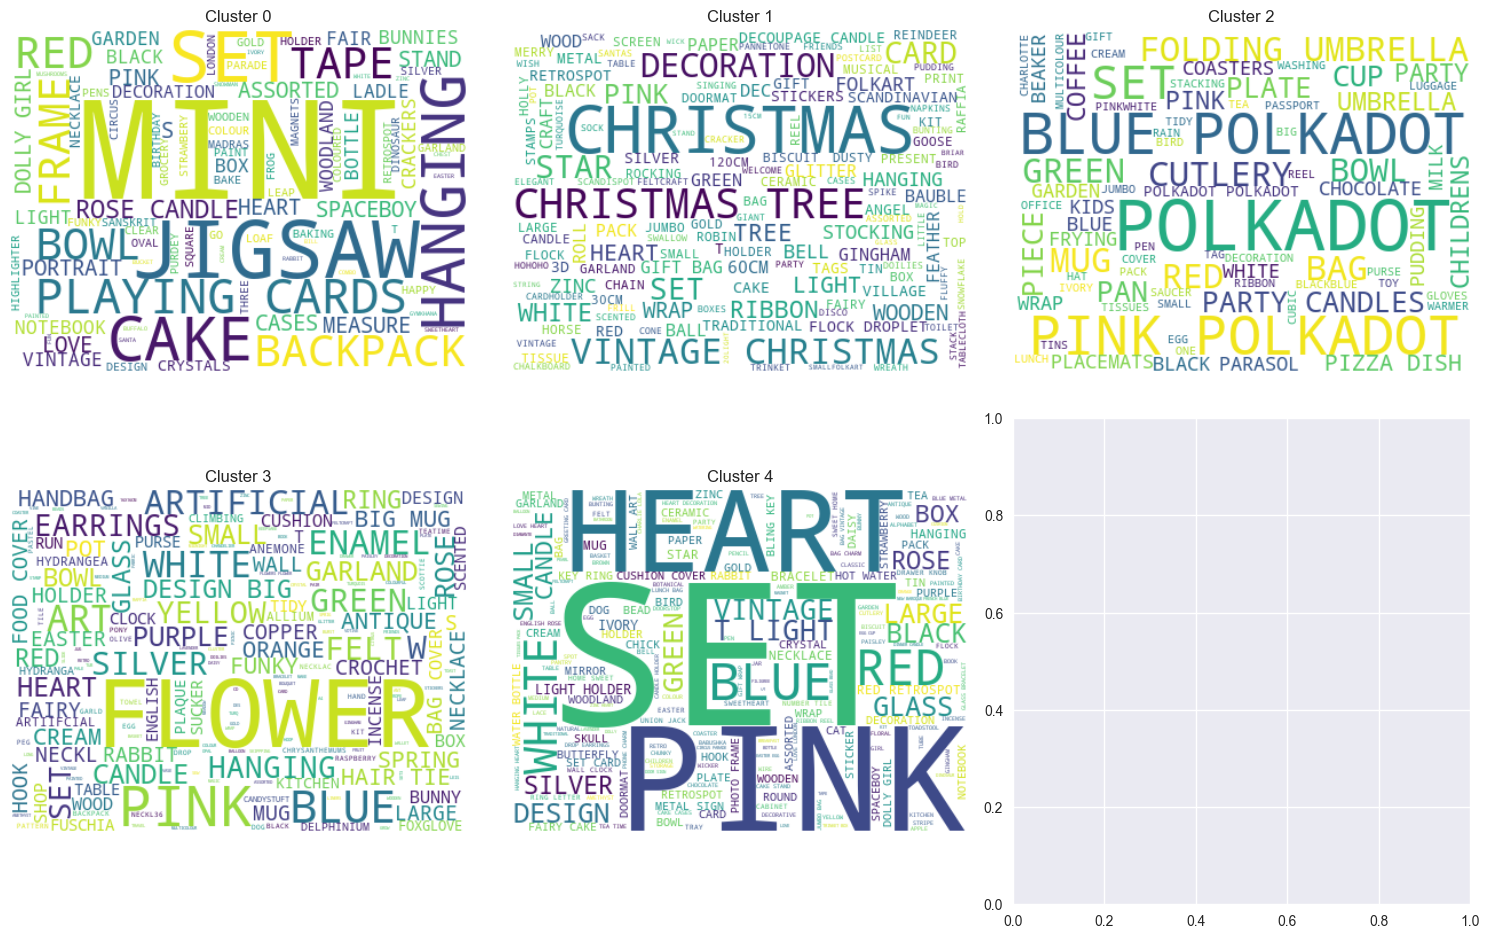

In [23]:
fig = px.scatter(
    product_clusters_df, 
    x='tsne_1', y='tsne_2', 
    color='product_clusters',
    hover_data=['StockCode', 'median_unit_price', 'mode_description'],
    title='Product Clusters (t-SNE Visualization)'
)
fig.show()

# Create word cloud for each cluster
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for cluster_id in sorted(product_clusters_df['product_clusters'].unique()):
    cluster_products = product_clusters_df[
        product_clusters_df['product_clusters'] == cluster_id
    ]
    
    # Get all descriptions for this cluster
    descriptions = ' '.join(cluster_products['mode_description'].astype(str))
    
    if len(descriptions) > 0:
        wordcloud = WordCloud(width=400, height=300, background_color='white').generate(descriptions)
        axes[cluster_id].imshow(wordcloud, interpolation='bilinear')
        axes[cluster_id].set_title(f'Cluster {cluster_id}')
        axes[cluster_id].axis('off')

plt.tight_layout()
plt.show()

In [24]:
transactions_with_clusters = ecommerce_df.merge(
    product_clusters_df[['StockCode', 'product_clusters']], 
    on='StockCode', 
    how='left'
)
transactions_with_clusters.head()

CustomerID InvoiceNo         InvoiceDate StockCode  \
0    14911.0   C562375 2011-08-04 14:46:00     23157   
1    14546.0    568060 2011-09-23 13:11:00     22178   
2    13969.0    557957 2011-06-23 19:20:00     20754   
3        nan    576644 2011-11-16 10:01:00     22624   
4    15785.0   C575590 2011-11-10 12:08:00     22197   

                       Description  Quantity  UnitPrice         Country  \
0       SET OF 6 NATIVITY MAGNETS       -240       1.85            EIRE   
1  VICTORIAN GLASS HANGING T-LIGHT         6       1.95  United Kingdom   
2  RETROSPOT RED WASHING UP GLOVES         6       2.10  United Kingdom   
3             IVORY KITCHEN SCALES         1      16.63  United Kingdom   
4                   POPCORN HOLDER       -10       0.72  United Kingdom   

   PriceExt  product_clusters  
0   -444.00               4.0  
1     11.70               4.0  
2     12.60               4.0  
3     16.63               4.0  
4     -7.20               4.0

In [25]:
# Customer spend habits
customer_spend = transactions_with_clusters.groupby(['CustomerID', 'InvoiceNo'])['PriceExt'].sum().reset_index()
customer_spend_habits = customer_spend.groupby('CustomerID')['PriceExt'].agg([
    'count', 'min', 'mean', 'max', 'sum'
]).reset_index()
customer_spend_habits.columns = ['CustomerID', 'order_count', 'min_order', 'mean_order', 'max_order', 'total_spend']
customer_spend_habits.head()

CustomerID  order_count  min_order  mean_order  max_order  total_spend
0    12346.0            2  -77183.60        0.00   77183.60         0.00
1    12347.0            7     182.34      563.38    1157.89      3943.66
2    12348.0            4     227.44      424.31     892.80      1697.24
3    12349.0            1    1477.77     1477.77    1477.77      1477.77
4    12350.0            1     279.20      279.20     279.20       279.20

In [26]:
# Customer product category preferences
customer_categories = transactions_with_clusters.groupby(['CustomerID', 'product_clusters'])['PriceExt'].sum().reset_index()
customer_categories_pivot = customer_categories.pivot(
    index='CustomerID', 
    columns='product_clusters', 
    values='PriceExt'
).fillna(0)
customer_categories_pivot.head()

product_clusters     0.0    1.0    2.0  3.0      4.0
CustomerID                                          
12346.0             0.00   0.00   0.00  0.0     0.00
12347.0           177.24  13.28  67.50  0.0  3685.64
12348.0             0.00  63.60   0.00  0.0  1273.64
12349.0             6.64  10.20  17.85  0.0  1143.08
12350.0             0.00   0.00  40.20  0.0   199.00

In [27]:
# Calculate proportions
customer_categories_pivot = customer_categories_pivot.div(
    customer_categories_pivot.sum(axis=1), axis=0
).fillna(0)
# Rename columns
customer_categories_pivot.columns = [f'cat_{int(col)}' for col in customer_categories_pivot.columns]
customer_categories_pivot = customer_categories_pivot.reset_index()
customer_categories_pivot.head()

CustomerID     cat_0     cat_1     cat_2  cat_3     cat_4
0    12346.0  0.000000  0.000000  0.000000    0.0  0.000000
1    12347.0  0.044943  0.003367  0.017116    0.0  0.934573
2    12348.0  0.000000  0.047561  0.000000    0.0  0.952439
3    12349.0  0.005638  0.008660  0.015156    0.0  0.970546
4    12350.0  0.000000  0.000000  0.168060    0.0  0.831940

In [28]:
# Customer recency
max_date = transactions_with_clusters['InvoiceDate'].max()
customer_recency = transactions_with_clusters.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max']).reset_index()
customer_recency['first_purchase_days'] = (max_date - customer_recency['min']).dt.days
customer_recency['last_purchase_days'] = (max_date - customer_recency['max']).dt.days
customer_recency = customer_recency[['CustomerID', 'first_purchase_days', 'last_purchase_days']]
customer_recency.head()

CustomerID  first_purchase_days  last_purchase_days
0    12346.0                  325                 325
1    12347.0                  366                   1
2    12348.0                  357                  74
3    12349.0                   18                  18
4    12350.0                  309                 309

In [29]:
# Join all customer features
customer_features = customer_spend_habits.merge(customer_categories_pivot, on='CustomerID')
customer_features = customer_features.merge(customer_recency, on='CustomerID')

print(f"Customer features shape: {customer_features.shape}")
print(f"Customer features columns: {list(customer_features.columns)}")

customer_features.head()

Customer features shape: (4349, 13)
Customer features columns: ['CustomerID', 'order_count', 'min_order', 'mean_order', 'max_order', 'total_spend', 'cat_0', 'cat_1', 'cat_2', 'cat_3', 'cat_4', 'first_purchase_days', 'last_purchase_days']


CustomerID  order_count  min_order  mean_order  max_order  total_spend  \
0    12346.0            2  -77183.60        0.00   77183.60         0.00   
1    12347.0            7     182.34      563.38    1157.89      3943.66   
2    12348.0            4     227.44      424.31     892.80      1697.24   
3    12349.0            1    1477.77     1477.77    1477.77      1477.77   
4    12350.0            1     279.20      279.20     279.20       279.20   

      cat_0     cat_1     cat_2  cat_3     cat_4  first_purchase_days  \
0  0.000000  0.000000  0.000000    0.0  0.000000                  325   
1  0.044943  0.003367  0.017116    0.0  0.934573                  366   
2  0.000000  0.047561  0.000000    0.0  0.952439                  357   
3  0.005638  0.008660  0.015156    0.0  0.970546                   18   
4  0.000000  0.000000  0.168060    0.0  0.831940                  309   

   last_purchase_days  
0                 325  
1                   1  
2                  74  
3                  18  
4                 309

In [30]:
# Select features for clustering
feature_cols = [col for col in customer_features.columns if col != 'CustomerID']
X_customers = customer_features[feature_cols].copy()

# Log transform skewed features
log_features = ['order_count', 'min_order', 'mean_order', 'max_order', 'total_spend', 
            'first_purchase_days', 'last_purchase_days']
for col in log_features:
    if col in X_customers.columns:
        X_customers[col] = np.log1p(X_customers[col])

# Scale features
scaler = MinMaxScaler()
X_customers_scaled = scaler.fit_transform(X_customers)

X_customers = X_customers_scaled
X_customers = np.nan_to_num(X_customers, nan=0)
customer_ids = customer_features['CustomerID'].values

print(f"Customer features shape: {X_customers.shape}")
X_customers[:1]

Customer features shape: (4349, 12)


array([[0.06096371, 0.        , 0.        , 0.92549317, 0.        ,
        0.03702347, 0.09877105, 0.11623989, 0.68026925, 0.62678627,
        0.97681423, 0.97681423]])

In [31]:
# K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=123)
customer_clusters = kmeans.fit_predict(X_customers)

# t-SNE for visualization
tsne = TSNE(n_components=2, random_state=123)
X_embedded = tsne.fit_transform(X_customers)

# Create customer clusters dataframe
customer_clusters_df = pd.DataFrame({
    'CustomerID': customer_ids,
    'customer_clusters': customer_clusters,
    'tsne_1': X_embedded[:, 0],
    'tsne_2': X_embedded[:, 1]
})

# Add customer features
customer_clusters_df = customer_clusters_df.merge(
    customer_features, on='CustomerID'
)

print(f"Customer cluster distribution:")
print(customer_clusters_df['customer_clusters'].value_counts().sort_index())

customer_clusters_df.head()

Customer cluster distribution:
customer_clusters
0     803
1    1439
2     683
3     712
4     712
Name: count, dtype: int64


CustomerID  customer_clusters     tsne_1     tsne_2  order_count  min_order  \
0    12346.0                  0 -10.068769  45.937504            2  -77183.60   
1    12347.0                  4  -9.474778 -50.669899            7     182.34   
2    12348.0                  1  -4.838231  -3.761770            4     227.44   
3    12349.0                  3  59.250061 -31.197422            1    1477.77   
4    12350.0                  1  48.538902  30.408325            1     279.20   

   mean_order  max_order  total_spend     cat_0     cat_1     cat_2  cat_3  \
0        0.00   77183.60         0.00  0.000000  0.000000  0.000000    0.0   
1      563.38    1157.89      3943.66  0.044943  0.003367  0.017116    0.0   
2      424.31     892.80      1697.24  0.000000  0.047561  0.000000    0.0   
3     1477.77    1477.77      1477.77  0.005638  0.008660  0.015156    0.0   
4      279.20     279.20       279.20  0.000000  0.000000  0.168060    0.0   

      cat_4  first_purchase_days  last_purchase_days  
0  0.000000                  325                 325  
1  0.934573                  366                   1  
2  0.952439                  357                  74  
3  0.970546                   18                  18  
4  0.831940                  309                 309

In [32]:
# Calculate cluster morphology
numeric_cols = ['order_count', 'mean_order', 'total_spend', 'first_purchase_days', 'last_purchase_days']
category_cols = [col for col in customer_clusters_df.columns if col.startswith('cat_')]

cluster_morphology = customer_clusters_df.groupby('customer_clusters')[numeric_cols + category_cols].mean()

print("Cluster Morphology:")
print(cluster_morphology)

cluster_morphology.head()

Cluster Morphology:
                   order_count  mean_order  total_spend  first_purchase_days  \
customer_clusters                                                              
0                     4.904110  198.537877  1044.758807           257.952677   
1                     1.831133  283.794790   507.221953           249.250174   
2                    17.238653  316.622973  7677.709839           290.676428   
3                     1.332865  269.903712   349.689594            43.022472   
4                     5.231742  290.186735  1603.199228           255.641854   

                   last_purchase_days     cat_0     cat_1     cat_2     cat_3  \
customer_clusters                                                               
0                          107.912827  0.015647  0.052309  0.021413  0.011584   
1                          184.767199  0.013954  0.029954  0.018758  0.015127   
2                            8.587116  0.014949  0.052919  0.021101  0.008393   
3             

order_count  mean_order  total_spend  first_purchase_days  \
customer_clusters                                                              
0                     4.904110  198.537877  1044.758807           257.952677   
1                     1.831133  283.794790   507.221953           249.250174   
2                    17.238653  316.622973  7677.709839           290.676428   
3                     1.332865  269.903712   349.689594            43.022472   
4                     5.231742  290.186735  1603.199228           255.641854   

                   last_purchase_days     cat_0     cat_1     cat_2     cat_3  \
customer_clusters                                                               
0                          107.912827  0.015647  0.052309  0.021413  0.011584   
1                          184.767199  0.013954  0.029954  0.018758  0.015127   
2                            8.587116  0.014949  0.052919  0.021101  0.008393   
3                           35.244382  0.018586  0.099100  0.012679  0.008266   
4                           18.251404  0.018132  0.063059  0.019030  0.009361   

                      cat_4  
customer_clusters            
0                  0.895311  
1                  0.922208  
2                  0.902638  
3                  0.861368  
4                  0.890419

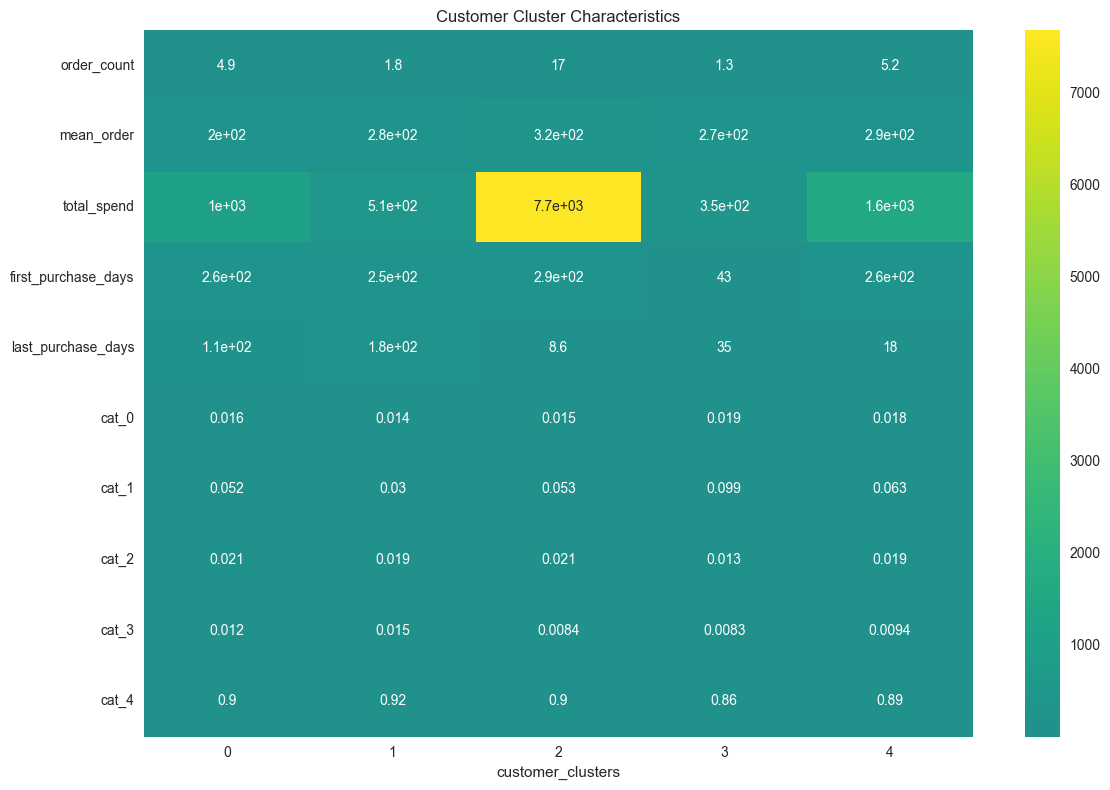

In [33]:
# t-SNE visualization
fig = px.scatter(
    customer_clusters_df, 
    x='tsne_1', y='tsne_2', 
    color='customer_clusters',
    hover_data=['CustomerID', 'order_count', 'total_spend'],
    title='Customer Clusters (t-SNE Visualization)'
)
fig.show()

# Cluster characteristics heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_morphology.T, annot=True, cmap='viridis', center=0)
plt.title('Customer Cluster Characteristics')
plt.tight_layout()
plt.show()

In [34]:
# Select features for prediction
feature_cols = ['order_count', 'mean_order', 'total_spend', 'first_purchase_days', 'last_purchase_days'] + [col for col in customer_clusters_df.columns if col.startswith('cat_')]

X = customer_clusters_df[feature_cols].copy()
y = customer_clusters_df['customer_clusters'].copy()

# Log transform and scale
X['mean_order'] = np.log1p(X['mean_order'])
X['total_spend'] = np.log1p(X['total_spend'])
X['first_purchase_days'] = np.log1p(X['first_purchase_days'])
X['last_purchase_days'] = np.log1p(X['last_purchase_days'])
X['order_count'] = np.log1p(X['order_count'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_prediction = X_scaled
X_prediction = np.nan_to_num(X_prediction, nan=0)
y_prediction = y.values
print(f"Prediction data shape: {X_prediction.shape}")

Prediction data shape: (4349, 10)


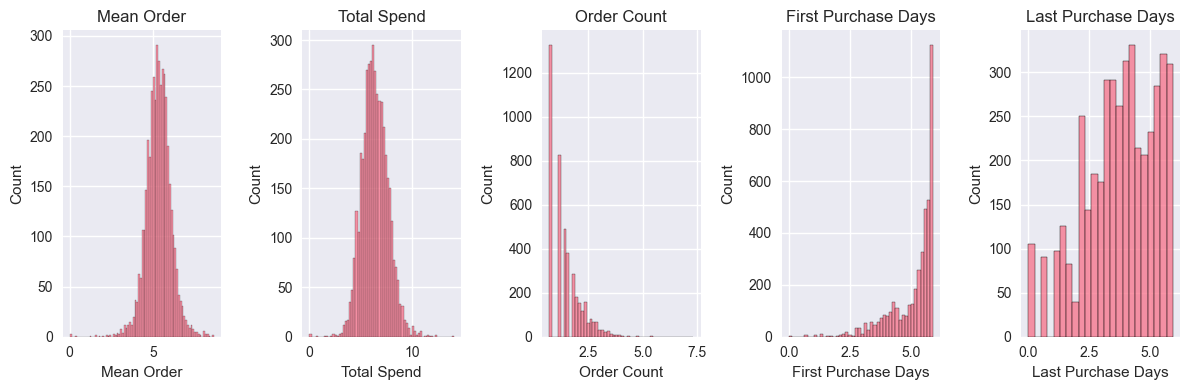

In [35]:
fig, axes = plt.subplots(1, 5, figsize=(12, 4))

sns.histplot(X['mean_order'], ax=axes[0])
axes[0].set_title('Mean Order')
axes[0].set_xlabel('Mean Order')
axes[0].set_ylabel('Count')

sns.histplot(X['total_spend'], ax=axes[1])
axes[1].set_title('Total Spend')
axes[1].set_xlabel('Total Spend')
axes[1].set_ylabel('Count')

sns.histplot(X['order_count'], ax=axes[2])
axes[2].set_title('Order Count')
axes[2].set_xlabel('Order Count')
axes[2].set_ylabel('Count') 

sns.histplot(X['first_purchase_days'], ax=axes[3])
axes[3].set_title('First Purchase Days')
axes[3].set_xlabel('First Purchase Days')
axes[3].set_ylabel('Count')

sns.histplot(X['last_purchase_days'], ax=axes[4])
axes[4].set_title('Last Purchase Days')
axes[4].set_xlabel('Last Purchase Days')
axes[4].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [36]:
customer_clusters_df['customer_clusters'].value_counts()

customer_clusters
1    1439
0     803
4     712
3     712
2     683
Name: count, dtype: int64

In [37]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X_prediction, y_prediction, 
    test_size=0.2, random_state=84, stratify=y_prediction
)

# SVM with grid search
svm_param_grid = {'C': np.logspace(-2, 2, 10)}
svm_grid = GridSearchCV(SVC(random_state=84, kernel='rbf'), svm_param_grid, cv=5)
svm_grid.fit(X_train, y_train)

# Logistic Regression with grid search
lr_param_grid = {'C': np.logspace(-2, 2, 20), 'penalty': ['l1', 'l2']}
lr_grid = GridSearchCV(LogisticRegression(max_iter=4000, random_state=84), lr_param_grid, cv=5)
lr_grid.fit(X_train, y_train)

# Random Forest with grid search
rf_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=84), rf_param_grid, cv=5)
rf_grid.fit(X_train, y_train)

# XGBoost with grid search
xgb_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30]}
xgb_grid = GridSearchCV(XGBClassifier(random_state=84), xgb_param_grid, cv=5)
xgb_grid.fit(X_train, y_train)

# CatBoost with grid search
cat_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30]}
cat_grid = GridSearchCV(CatBoostClassifier(random_state=84), cat_param_grid, cv=5)
cat_grid.fit(X_train, y_train)

# LightGBM with grid search
lgbm_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'learning_rate': [0.01, 0.05, 0.1], 'subsample': [0.5, 0.75, 1.0], 'colsample_bytree': [0.5, 0.75, 1.0]}
lgbm_grid = GridSearchCV(LGBMClassifier(random_state=84), lgbm_param_grid, cv=5)
lgbm_grid.fit(X_train, y_train)

# Evaluate models
print("Evaluating models...")
print("-" * 50)

# Predictions
svm_predictions = svm_grid.predict(X_val)
lr_predictions = lr_grid.predict(X_val)
rf_predictions = rf_grid.predict(X_val)
xgb_predictions = xgb_grid.predict(X_val)
cat_predictions = cat_grid.predict(X_val)
lgbm_predictions = lgbm_grid.predict(X_val)

svm_accuracy = accuracy_score(y_val, svm_predictions)
lr_accuracy = accuracy_score(y_val, lr_predictions)
rf_accuracy = accuracy_score(y_val, rf_predictions)
xgb_accuracy = accuracy_score(y_val, xgb_predictions)
cat_accuracy = accuracy_score(y_val, cat_predictions)
lgbm_accuracy = accuracy_score(y_val, lgbm_predictions)

Learning rate set to 0.5
0:	learn: 0.9543143	total: 59.9ms	remaining: 5.92s
1:	learn: 0.7810202	total: 62ms	remaining: 3.04s
2:	learn: 0.6790649	total: 64.1ms	remaining: 2.07s
3:	learn: 0.6120263	total: 66ms	remaining: 1.58s
4:	learn: 0.5510181	total: 68.1ms	remaining: 1.29s
5:	learn: 0.5287938	total: 70.1ms	remaining: 1.1s
6:	learn: 0.5038312	total: 71.9ms	remaining: 955ms
7:	learn: 0.4895670	total: 73.7ms	remaining: 848ms
8:	learn: 0.4740911	total: 75.7ms	remaining: 765ms
9:	learn: 0.4631346	total: 78ms	remaining: 702ms
10:	learn: 0.4583901	total: 80.2ms	remaining: 649ms
11:	learn: 0.4489322	total: 82.1ms	remaining: 602ms
12:	learn: 0.4401626	total: 84ms	remaining: 562ms
13:	learn: 0.4358875	total: 86.6ms	remaining: 532ms
14:	learn: 0.4267224	total: 88.8ms	remaining: 503ms
15:	learn: 0.4155446	total: 90.8ms	remaining: 477ms
16:	learn: 0.4092817	total: 92.9ms	remaining: 454ms
17:	learn: 0.4019359	total: 94.7ms	remaining: 431ms
18:	learn: 0.3942541	total: 96.9ms	remaining: 413ms
19:	le

In [39]:
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
print(f"CatBoost Accuracy: {cat_accuracy:.4f}")
print(f"LightGBM Accuracy: {lgbm_accuracy:.4f}")

SVM Accuracy: 0.7586
Logistic Regression Accuracy: 0.7621
Random Forest Accuracy: 0.7782
XGBoost Accuracy: 0.7747
CatBoost Accuracy: 0.7724
LightGBM Accuracy: 0.7839


In [41]:
# Create ensemble weights based on validation accuracy
total_accuracy = rf_accuracy + xgb_accuracy + lgbm_accuracy
rf_weight = rf_accuracy / total_accuracy
xgb_weight = xgb_accuracy / total_accuracy 
lgbm_weight = lgbm_accuracy / total_accuracy

print("\nEnsemble Weights:")
print(f"Random Forest Weight: {rf_weight:.4f}")
print(f"XGBoost Weight: {xgb_weight:.4f}")
print(f"LightGBM Weight: {lgbm_weight:.4f}")

# Get probabilities for each model
rf_proba = rf_grid.predict_proba(X_val)
xgb_proba = xgb_grid.predict_proba(X_val)
lgbm_proba = lgbm_grid.predict_proba(X_val)

# Calculate weighted ensemble probabilities
ensemble_proba = (rf_weight * rf_proba + 
                 xgb_weight * xgb_proba + 
                 lgbm_weight * lgbm_proba)

# Make ensemble predictions
ensemble_predictions = np.argmax(ensemble_proba, axis=1)

# Calculate ensemble accuracy
ensemble_accuracy = accuracy_score(y_val, ensemble_predictions)
print(f"\nEnsemble Accuracy: {ensemble_accuracy:.4f}")

# Compare with individual model accuracies
print("\nAccuracy Comparison:")
print(f"Random Forest: {rf_accuracy:.4f}")
print(f"XGBoost: {xgb_accuracy:.4f}") 
print(f"LightGBM: {lgbm_accuracy:.4f}")
print(f"Weighted Ensemble: {ensemble_accuracy:.4f}")



Ensemble Weights:
Random Forest Weight: 0.3330
XGBoost Weight: 0.3315
LightGBM Weight: 0.3355

Ensemble Accuracy: 0.7782

Accuracy Comparison:
Random Forest: 0.7782
XGBoost: 0.7747
LightGBM: 0.7839
Weighted Ensemble: 0.7782
